In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

In [2]:
from qiskit import Aer
from collections import defaultdict
from qiskit import QuantumCircuit, transpile,execute, Aer
import networkx as nx
from qiskit.circuit.quantumcircuit import QuantumCircuit
from qiskit.circuit import QuantumCircuit, ParameterVector
import numpy as np
#from qiskit.optimization.applications.ising import tsp
from qiskit_optimization.applications import Tsp
#from qiskit.aqua.algorithms import NumPyMinimumEigensolver, QAOA
from qiskit.algorithms.minimum_eigensolvers import QAOA , NumPyMinimumEigensolver
#from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.utils import QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
#from qiskit.optimization.problems import QuadraticProgram
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.primitives import Sampler
from qiskit.circuit.library.n_local.qaoa_ansatz import QAOAAnsatz
from qiskit.quantum_info.operators import Operator # Generating a TSP instance of n cities
import itertools
#THE BELOW FUNCTION CALCULATES TSP CLASSICALLY

def tsp_brute_force(distances):
    num_cities = len(distances)
    all_cities = set(range(num_cities))
    shortest_path = None
    shortest_distance = float('inf')

    for permutation in itertools.permutations(all_cities):
        distance = 0
        for i in range(num_cities - 1):
            current_city = permutation[i]
            next_city = permutation[i + 1]
            distance += distances[current_city][next_city]

        # Add the last leg of the path to complete the cycle
        distance += distances[permutation[-1]][permutation[0]]

        if distance < shortest_distance:
            shortest_distance = distance
            shortest_path = permutation

    return  shortest_distance #,shortest_path
def invert_counts(counts):
    return {k[::-1]:v for k, v in counts.items()} #MSB most significant bit

def tsp_obj( result, adj_matrix: np.ndarray) -> float:
    x = result
    n = int(np.sqrt(len(x)))
    total_cost = 0.0

    for p__ in range(n):
        for i in range(n):
            if x[i * n + p__]:
                total_cost += adj_matrix[i, p__]

    return total_cost

In [105]:
#THIS PART CREATES AN INSTANCE OF TSP THEN IT CONVERTS THAT INTO PAULI OPERATOR LIST(IN SHORT THIS WHERE ENCODING PART IS DONE)
n = 3
num_qubits = n ** 2
tsp =Tsp.create_random_instance(n, seed=46516)
adj_matrix = nx.to_numpy_array(tsp.graph)
print("distance\n", adj_matrix)

# Create a random TSP Hamiltonian
qp = tsp.to_quadratic_program()
print(qp.prettyprint())

qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()
print(qubitOp, offset)



distance
 [[ 0. 62. 29.]
 [62.  0. 76.]
 [29. 76.  0.]]
Problem name: TSP

Minimize
  62*x_0_0*x_1_1 + 62*x_0_0*x_1_2 + 29*x_0_0*x_2_1 + 29*x_0_0*x_2_2
  + 62*x_0_1*x_1_0 + 62*x_0_1*x_1_2 + 29*x_0_1*x_2_0 + 29*x_0_1*x_2_2
  + 62*x_0_2*x_1_0 + 62*x_0_2*x_1_1 + 29*x_0_2*x_2_0 + 29*x_0_2*x_2_1
  + 76*x_1_0*x_2_1 + 76*x_1_0*x_2_2 + 76*x_1_1*x_2_0 + 76*x_1_1*x_2_2
  + 76*x_1_2*x_2_0 + 76*x_1_2*x_2_1

Subject to
  Linear constraints (6)
    x_0_0 + x_0_1 + x_0_2 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 == 1  'c1'
    x_2_0 + x_2_1 + x_2_2 == 1  'c2'
    x_0_0 + x_1_0 + x_2_0 == 1  'c3'
    x_0_1 + x_1_1 + x_2_1 == 1  'c4'
    x_0_2 + x_1_2 + x_2_2 == 1  'c5'

  Binary variables (9)
    x_0_0 x_0_1 x_0_2 x_1_0 x_1_1 x_1_2 x_2_0 x_2_1 x_2_2

-1048.5 * IIIIIIIIZ
- 1048.5 * IIIIIIIZI
- 1048.5 * IIIIIIZII
- 1072.0 * IIIIIZIII
- 1072.0 * IIIIZIIII
- 1072.0 * IIIZIIIII
- 1055.5 * IIZIIIIII
- 1055.5 * IZIIIIIII
- 1055.5 * ZIIIIIIII
+ 501.5 * IIIIIIIZZ
+ 501.5 * IIIIIIZIZ
+ 501.5 * IIIIIIZZI
+ 501.5 * II

In [102]:
def getckt(qubitOp, theta, p,num_qubits):
    circuit = QAOAAnsatz( cost_operator=qubitOp, reps=p)  #CREATES STANDARD QAOA CIRCUIT
    circuit =circuit.decompose( reps=3) # DECOMPOSES FOR VISUALIZATION PURPOSES
    bind_dict = {}     # THESE LINES ASSIGNS THE PARAMETERS OF BETA AND GAMMA TO THE QAOA CIRCUIT
    phi = ParameterVector('φ',num_qubits)
    circuit.parameters
    
    param =theta #[beta:p,gamma:p,alpha:2**n]

    
    for i in range(num_qubits - 1):
    
        # THE BELOW LINES CONSTRUCTS THE PROBLEM INDEPENDENT LAYER WITH passed PARAMETERS 
        circuit.crz(phi[i], i, i+1)
        circuit.x(range(num_qubits))


    for i, key in enumerate(circuit.parameters):
        bind_dict[key] = param[i]

        
    circuit = circuit.bind_parameters(bind_dict)
    circuit.measure_all()
    return circuit


In [20]:
def compute_tsp_energy(counts, distances):
    energy = 0
    total_counts = 0
    #counts =  correct_dict(counts, adj_matrix)
    
    for meas, meas_count in counts.items():
        binary_list = [int(bit) for bit in meas]
        meas_arr = np.array(binary_list)
        obj_for_meas = tsp_obj(meas_arr,adj_matrix)
        energy += obj_for_meas * meas_count
        total_counts += meas_count
    return (energy /total_counts)
    

In [21]:
def get_black_box_objective(adj_matrix,p):
    backend = Aer.get_backend('qasm_simulator')
    def f(theta):
        # let's assume first half is betas, second half is gammas
        circuit = getckt(qubitOp, theta , p,num_qubits)
        counts = execute(circuit, backend, seed_simulator=10,shots = 5048).result().get_counts()
        
        # return the energy
        return -compute_tsp_energy(invert_counts(counts), adj_matrix)
    return f


In [48]:
methods = ['Nelder-Mead',
           'Powell',
           'CG',
           'BFGS',
           'L-BFGS-B',
           'TNC',
           'COBYLA',
           'SLSQP',
           'trust-constr']

print(methods)
op_fun =  [203.973059,240.024960, 203.642235, 203.642235,203.64223454833598,204.4033203125
           , 231.6748046875,199.2294921875, 199.103515625]
op_fun_time = [47.573213, 176.164262, 2.730547,2.695026, 2.754663,2.631764,28.988978,2.708305,2.667684]

['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP', 'trust-constr']


In [200]:
from scipy.optimize import minimize
import time

# Record the start time
start_time = time.time()
# p is the number of QAOA alternating operators
p = 1
obj = get_black_box_objective(adj_matrix, p)
random_params = []
for i in range((num_qubits + (2 * p)) - 1):
    random_value = np.random.uniform(low=-(-0.00000001 * np.pi), high=-0.00000001 *np.pi * np.pi)
    random_params.append(random_value)
init_point = np.array(random_params)
# We are going to limit the number of iterations to 2500
res_sample = minimize(obj, init_point, method= 'TNC', options={'maxiter':2500, 'disp': True})
#print(res_sample)
end_time = time.time()

# Calculate the running time
running_time = end_time - start_time

print(f"Optimization time: {running_time:.6f} seconds")

Optimization time: 2.531979 seconds


/tmp/ipykernel_608/2172968632.py:15: DeprecationWarning: 'maxiter' has been deprecated in favor of 'maxfun' and will be removed in SciPy 1.11.0.
  res_sample = minimize(obj, init_point, method= 'TNC', options={'maxiter':2500, 'disp': True})
  NIT   NF   F                       GTG
    0    1 -1.682555467511886E+02   0.00000000E+00
tnc: |pg| = 0 -> local minimum
    0    1 -1.682555467511886E+02   0.00000000E+00
tnc: Local minima reach (|pg| ~= 0)


In [201]:
obtained_cost =-1*res_sample['fun']
correct_cost = tsp_brute_force(adj_matrix)
approximation_ratio = correct_cost/obtained_cost
error = ((obtained_cost-correct_cost)/correct_cost)*100
print('obtained_cost',obtained_cost)
print('correct_cost',correct_cost)

print('approximation_ratio',approximation_ratio)
print('error %',abs(error))

obtained_cost 168.2555467511886
correct_cost 167.0
approximation_ratio 0.9925378581839844
error % 0.7518244019093434


In [43]:
approx_list = []
n_cities = []
approx_list.append(approximation_ratio)
n_cities.append(n)
print(approx_list)

[0.9916559367329394]


In [77]:
seed_list = []  # Initialize seed_list outside the loop

for i in range(0, 10):
    tsp = Tsp.create_random_instance(n, seed=i)
    adj_matrix = nx.to_numpy_array(tsp.graph)
    added_val = tsp_brute_force(adj_matrix)
    seed_list.append(added_val)

min_value = min(seed_list)
min_index = seed_list.index(min_value)

max_value = max(seed_list)
max_index = seed_list.index(min_value)


print("Max value:", max_value)
print("Index of max value:", max_index)

print("Minimum value:", min_value)
print("Index of minimum value:", min_index)


Max value: 193.0
Index of max value: 0
Minimum value: 91.0
Index of minimum value: 0


In [230]:
import numpy as np
import time
from scipy.optimize import minimize

# Define the initial and final bounds
initial_lb = -0.0000000001 *(np.pi)**2
initial_ub = 0.00000000001 *(np.pi)**2

final_lb = -100000 *(np.pi)**2
final_ub = 100000 *(np.pi)**2

# Define the number of iterations
num_iterations = 30

# Calculate the step sizes to increase the bounds in each iteration
lb_step = 100
ub_step = 100

# Start with the initial bounds range
lb = initial_lb
ub = initial_ub
ap_list = []
t_list = []
cost_list = []
b_list = []
for i in range(num_iterations):
    # Your code here - you can use 'lb' and 'ub' as the lower and upper bounds for your optimization

    # Record the start time
    start_time = time.time()

    # p is the number of QAOA alternating operators
    p = 1
    obj = get_black_box_objective(adj_matrix, p)

    random_params = []
    for i in range((num_qubits + (2 * p)) - 1):
        random_value = np.random.uniform(low=lb, high=ub)
        random_params.append(random_value)
    init_point = np.array(random_params)

    # We are going to limit the number of iterations to 2500
    res_sample = minimize(obj, init_point, method='TNC', options={'maxiter': 2500, 'disp': True})

    # Calculate the running time
    end_time = time.time()
    running_time = end_time - start_time

    obtained_cost = -1 * res_sample['fun']

    ap_list.append(correct_cost / obtained_cost)
    t_list.append(running_time)
    cost_list.append(obtained_cost)
    b_list.append(abs(ub))

    # After running the optimization, you can adjust the bounds range for the next iteration
    lb *= 10
    ub *= 10


/tmp/ipykernel_608/2164073902.py:43: DeprecationWarning: 'maxiter' has been deprecated in favor of 'maxfun' and will be removed in SciPy 1.11.0.
  res_sample = minimize(obj, init_point, method='TNC', options={'maxiter': 2500, 'disp': True})
  NIT   NF   F                       GTG
    0    1 -1.682555467511886E+02   0.00000000E+00
tnc: |pg| = 0 -> local minimum
    0    1 -1.682555467511886E+02   0.00000000E+00
tnc: Local minima reach (|pg| ~= 0)
  NIT   NF   F                       GTG
    0    1 -1.682555467511886E+02   0.00000000E+00
tnc: |pg| = 0 -> local minimum
    0    1 -1.682555467511886E+02   0.00000000E+00
tnc: Local minima reach (|pg| ~= 0)
  NIT   NF   F                       GTG
    0    1 -1.682555467511886E+02   0.00000000E+00
tnc: |pg| = 0 -> local minimum
    0    1 -1.682555467511886E+02   0.00000000E+00
tnc: Local minima reach (|pg| ~= 0)
  NIT   NF   F                       GTG
    0    1 -1.682555467511886E+02   0.00000000E+00
tnc: |pg| = 0 -> local minimum
    0 

In [117]:
lower_bound = 0.1
upper_bound = 10

# Exclude the endpoints and count the numbers in between
count = int(upper_bound) - int(lower_bound) - 1

print("Number of numbers between 0.01 and 100 (excluding endpoints):", count)


Number of numbers between 0.01 and 100 (excluding endpoints): 9


In [231]:
print(ap_list)

[0.9925378581839844, 0.9925378581839844, 0.9925378581839844, 0.9925378581839844, 0.9925378581839844, 0.9922095958852919, 0.991180658352508, 0.9928581523531352, 1.0345836462797422, 0.9927190211010611, 0.9983834311762108, 0.9936609641275163, 0.9911538551978742, 0.9882989037476099, 0.999077974007874, 0.906916424342767, 0.9788614072346123, 0.9895692227509736, 0.9802067115561038, 0.9437584382493669, 0.8524026580706743, 0.9862893177417562, 0.9799810982322313, 0.98488124987587, 0.9279616053541159, 0.9676347804727432, 0.8706351591538373, 0.9715221492474015, 0.9830253517776328, 0.915001948276779]


In [181]:
print(t_list)

[2.3502676486968994, 2.529364824295044, 2.3466947078704834, 4.807341814041138, 66.68801879882812, 2.254000425338745, 2.3870768547058105, 2.3323278427124023]


In [208]:
print(cost_list)
print(correct_cost)

[168.2555467511886, 168.2555467511886, 168.2555467511886, 168.2555467511886, 168.2555467511886, 168.26782884310617, 168.3930269413629, 168.5818145800317, 170.20443740095087, 169.05586370839936, 169.17729793977813, 148.93363708399366, 105.36925515055468, 170.1562995245642, 166.64560221870047, 169.85637876386687, 169.07309825673534, 168.72167194928684, 243.0235736925515, 182.95820126782885, 169.04338351822503, 169.61073692551506, 176.6553090332805, 183.40649762282092, 190.73573692551506, 168.62876386687796, 173.45602218700475, 170.5986529318542, 191.71572900158478, 177.56557052297939]
167.0


In [232]:
print(b_list)

[9.869604401089358e-11, 9.869604401089357e-10, 9.869604401089357e-09, 9.869604401089357e-08, 9.869604401089357e-07, 9.869604401089357e-06, 9.869604401089357e-05, 0.0009869604401089357, 0.009869604401089357, 0.09869604401089357, 0.9869604401089358, 9.869604401089358, 98.69604401089359, 986.9604401089359, 9869.60440108936, 98696.0440108936, 986960.440108936, 9869604.401089361, 98696044.01089361, 986960440.1089361, 9869604401.089361, 98696044010.89362, 986960440108.9362, 9869604401089.361, 98696044010893.61, 986960440108936.1, 9869604401089362.0, 9.869604401089362e+16, 9.869604401089362e+17, 9.869604401089362e+18]


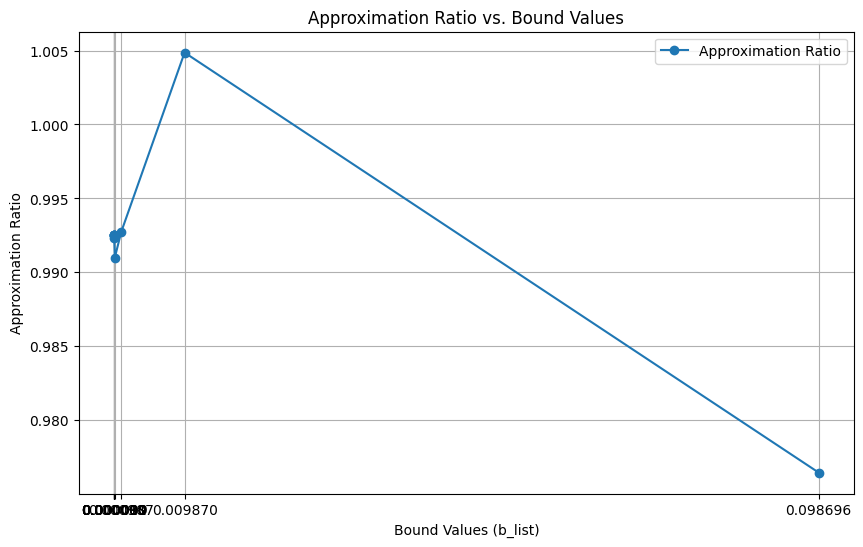

In [227]:
import matplotlib.pyplot as plt

# Assuming you have b_list and ap_list containing the data
plt.figure(figsize=(10, 6))  # Increase the figure size for better readability
plt.errorbar(b_list, ap_list, marker='o', linestyle='-', capsize=1, label='Approximation Ratio')
plt.xlabel('Bound Values (b_list)')
plt.ylabel('Approximation Ratio')
plt.title('Approximation Ratio vs. Bound Values')
plt.grid(True)



# Set custom tick locations and labels for the x-axis
plt.xticks(b_list, ["{:.6f}".format(val) for val in b_list])

# Add a legend
plt.legend()

plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

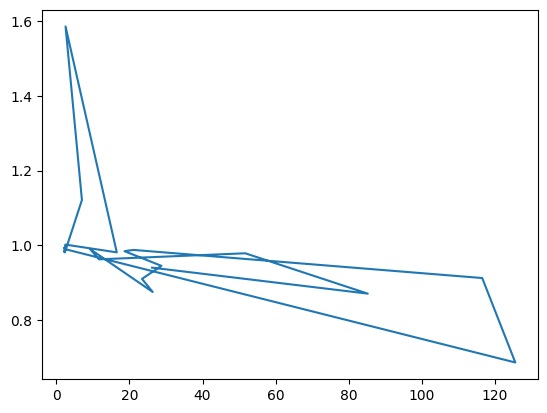

In [204]:
plt.plot(t_list,ap_list )
plt.show

/tmp/ipykernel_608/1454428835.py:43: DeprecationWarning: 'maxiter' has been deprecated in favor of 'maxfun' and will be removed in SciPy 1.11.0.
  res_sample = minimize(obj, init_point, method='TNC', options={'maxiter': 2500, 'disp': True})
  NIT   NF   F                       GTG
    0    1 -1.682555467511886E+02   0.00000000E+00
tnc: |pg| = 0 -> local minimum
    0    1 -1.682555467511886E+02   0.00000000E+00
tnc: Local minima reach (|pg| ~= 0)
  NIT   NF   F                       GTG
    0    1 -1.683674722662441E+02   0.00000000E+00
tnc: |pg| = 0 -> local minimum
    0    1 -1.683674722662441E+02   0.00000000E+00
tnc: Local minima reach (|pg| ~= 0)
  NIT   NF   F                       GTG
    0    1 -1.688870839936609E+02   0.00000000E+00
tnc: |pg| = 0 -> local minimum
    0    1 -1.688870839936609E+02   0.00000000E+00
tnc: Local minima reach (|pg| ~= 0)
  NIT   NF   F                       GTG
    0    1 -1.652105784469097E+02   0.00000000E+00
tnc: |pg| = 0 -> local minimum
    0 

Traceback (most recent call last):
  Cell In[206], line 23
    root = tk.Tk()
  File /opt/conda/lib/python3.10/tkinter/__init__.py:2299 in __init__
    self.tk = _tkinter.create(screenName, baseName, className, interactive, wantobjects, useTk, sync, use)
TclError: no display name and no $DISPLAY environment variable

Use %tb to get the full traceback.


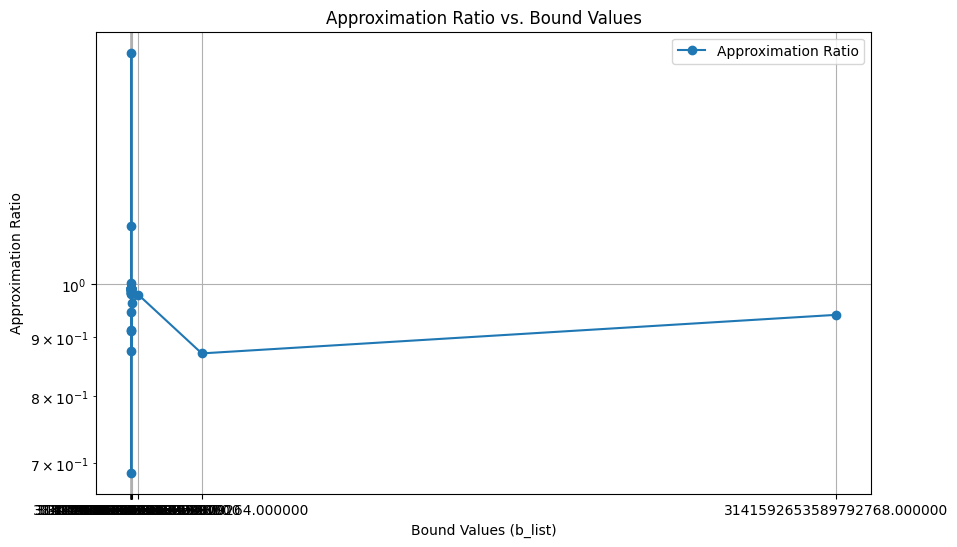

In [206]:
import matplotlib.pyplot as plt
import tkinter as tk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk

# Assuming you have b_list and ap_list containing the data
plt.figure(figsize=(10, 6))  # Increase the figure size for better readability
plt.errorbar(b_list, ap_list, marker='o', linestyle='-', capsize=5, label='Approximation Ratio')
plt.xlabel('Bound Values (b_list)')
plt.ylabel('Approximation Ratio')
plt.title('Approximation Ratio vs. Bound Values')
plt.grid(True)

# Set a logarithmic scale for the y-axis to handle a wide range of values
plt.yscale('log')

# Set custom tick locations and labels for the x-axis
plt.xticks(b_list, ["{:.6f}".format(val) for val in b_list])

# Add a legend
plt.legend()

# Embed the plot in a Tkinter window
root = tk.Tk()
root.title("Interactive Plot")

# Create a FigureCanvasTkAgg object
canvas = FigureCanvasTkAgg(plt.gcf(), master=root)
canvas.draw()

# Add NavigationToolbar2Tk to the plot window
toolbar = NavigationToolbar2Tk(canvas, root)
toolbar.update()

# Pack the canvas and toolbar
canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)
toolbar.pack(side=tk.BOTTOM, fill=tk.BOTH, expand=True)

# Run the Tkinter event loop
root.mainloop()
